In [1]:
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import torch
import normflows as nf
import random
from torch.utils.data import DataLoader
import pandas as pd
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print(f"Using device: {device}")

from GPDFlow import T_mGPD_NF
import Common_Functions as cf

/home/pgrad2/2448355h/.local/lib/python3.10/site-packages/matplotlib/projections/__init__.py:63: UserWarning: Unable to import Axes3D. This may be due to multiple versions of Matplotlib being installed (e.g. as a system package and as a pip package). As a result, the 3D projection is not available.
  warnings.warn("Unable to import Axes3D. This may be due to multiple versions of "


Using device: cuda


In [2]:
# Directory for saving plots and the model weights in all repeated experiments. Not uploaded to GitHub for file size considerations.
dir_out = "/home/pgrad2/2448355h/My_PhD_Project/01_Output/GPDFlow/"

#### Parameter settings for the T-representation mGPD with reverse exponential 

In [3]:
n_samples = 100
n_experiments = 100    
d = 5
a = np.array([2, 0.5, 1, 5, 1.5]) # alpha = 1/a, which is requred in computing the bivariate tail dependence coefficient
beta = np.array([1, 2, 3, 4, 5])
sig = np.array([0.5, 1.2, 1, 1.5, 0.8])
gamma = np.array([-0.1, 0.2, 0, 0.15, -0.05])

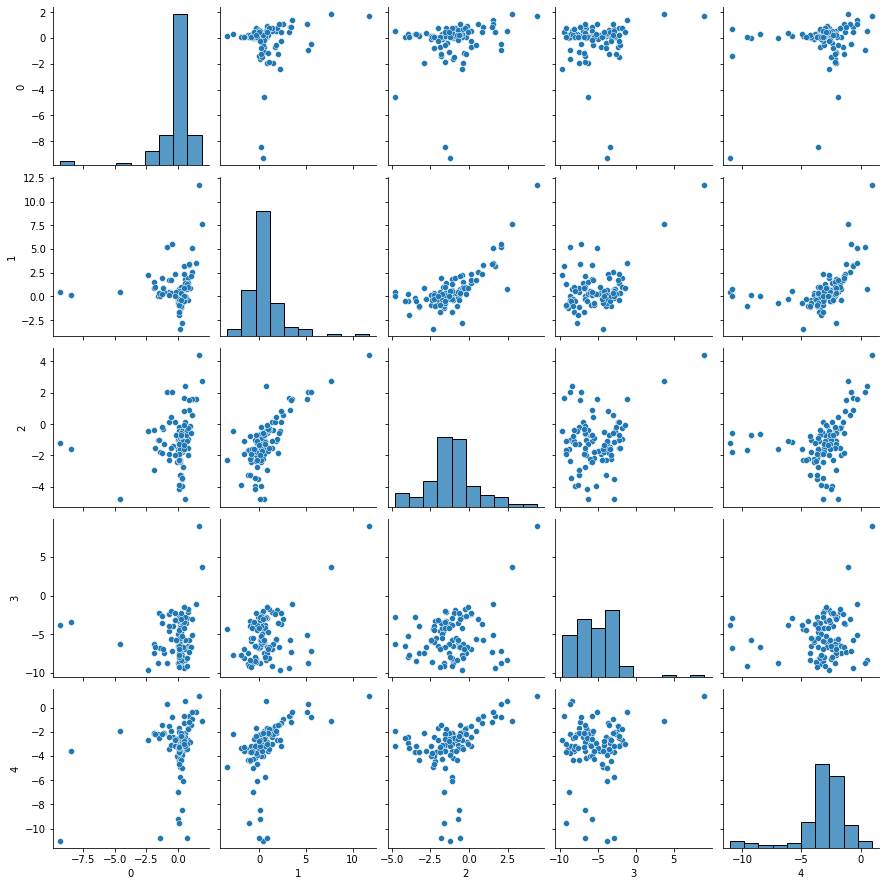

In [4]:
samples = cf.sim_revexp_T_mgpd(n_samples, 5, a, beta, sig, gamma)

sns.pairplot(pd.DataFrame(samples), diag_kws={'bins': 10})

#### Fit a GPDFlow on the simulated data. Repeat for 100 times

In [6]:
dim = 3
base = nf.distributions.DiagGaussian(dim)


num_layers = 16
torch.manual_seed(0)

latent_size = dim
b = torch.Tensor([1 if i % 2 == 0 else 0 for i in range(latent_size)])
flows = []
for i in range(num_layers):
    s = nf.nets.MLP([latent_size, 4 * latent_size, latent_size], init_zeros=True, output_fn='tanh')
    t = nf.nets.MLP([latent_size, 4 * latent_size, latent_size], init_zeros=True, output_fn='tanh')
    if i % 2 == 0:
        flows += [nf.flows.MaskedAffineFlow(b, t, s)]
    else:
        flows += [nf.flows.MaskedAffineFlow(1 - b, t, s)]
    flows += [nf.flows.ActNorm(latent_size)]


f_T_model = nf.NormalizingFlow(base, flows)
f_T_model = f_T_model.to(device)

batch_size = 64
loss_history = []
epochs = 200

model = T_mGPD_NF(dim=dim, flow =f_T_model, device=device, s_min=-10,
                  s_max = 10, num_integration_points=1000, penalty_lambda=10000, fix_margin=False)

optimizer = torch.optim.Adam([
    {'params': model.flow_model.parameters(), 'lr': 1e-2},  # Flow layers
    {'params': model.data_transform.log_sigma, 'lr': 1e-1},  # Faster for log_sigma
    {'params': model.data_transform.theta, 'lr': 1e-1}       # Faster for gamma
], weight_decay = 1e-5 )

scheduler = torch.optim.lr_scheduler.CosineAnnealingLR(optimizer, epochs)

seed = 1234
random.seed(seed)
np.random.seed(seed)
torch.manual_seed(seed)
if torch.cuda.is_available():
    torch.cuda.manual_seed(seed)
    torch.cuda.manual_seed_all(seed)  # for multi-GPU setups

for i in range(n_experiments):
    

    samples = sim_revexp_T_mgpd(n_samples, dim, a, beta, sig, gamma)

    data = torch.tensor(samples, dtype=torch.float, device = device)

    memory = torch.cuda.memory_allocated(device) /10**9

    Training_Data = DataLoader(data, batch_size=batch_size, shuffle=True)
    torch.autograd.set_detect_anomaly(True)

    for epoch in range(epochs):
        epoch_loss = 0.0
        
        for x_data in Training_Data:
            # Sample a batch of data from h_U

            batch_loss = model(x_data)

            # Backpropagation
            optimizer.zero_grad()
            batch_loss.backward()

            torch.nn.utils.clip_grad_norm_(model.parameters(), max_norm=1)
            optimizer.step()

            # Record loss
            loss_history.append(batch_loss.item())
            epoch_loss += batch_loss.item()

            if torch.isnan(batch_loss) or torch.isinf(batch_loss):
                print("NaN or Inf detected!")
                break

        # Debugging: Print shapes
        scheduler.step()
    torch.save(model.state_dict(), dir_out + f'model_{dim}D_100_{i}.pt')
    print(f"Completed Experiment {i} \n")



Completed Experiment 0 

Completed Experiment 1 

Completed Experiment 2 

Completed Experiment 3 

Completed Experiment 4 

Completed Experiment 5 

Completed Experiment 6 

Completed Experiment 7 

Completed Experiment 8 

Completed Experiment 9 

Completed Experiment 10 

Completed Experiment 11 

Completed Experiment 12 

Completed Experiment 13 

Completed Experiment 14 

Completed Experiment 15 

Completed Experiment 16 

Completed Experiment 17 

Completed Experiment 18 

Completed Experiment 19 

Completed Experiment 20 

Completed Experiment 21 

Completed Experiment 22 

Completed Experiment 23 

Completed Experiment 24 

Completed Experiment 25 

Completed Experiment 26 

Completed Experiment 27 

Completed Experiment 28 

Completed Experiment 29 

Completed Experiment 30 

Completed Experiment 31 

Completed Experiment 32 

Completed Experiment 33 

Completed Experiment 34 

Completed Experiment 35 

Completed Experiment 36 

Completed Experiment 37 

Completed Experiment 3

#### Compare the true $f_{\boldsymbol{T}}$ and fitted $f_{\boldsymbol{T}}$ from the normalizing flow

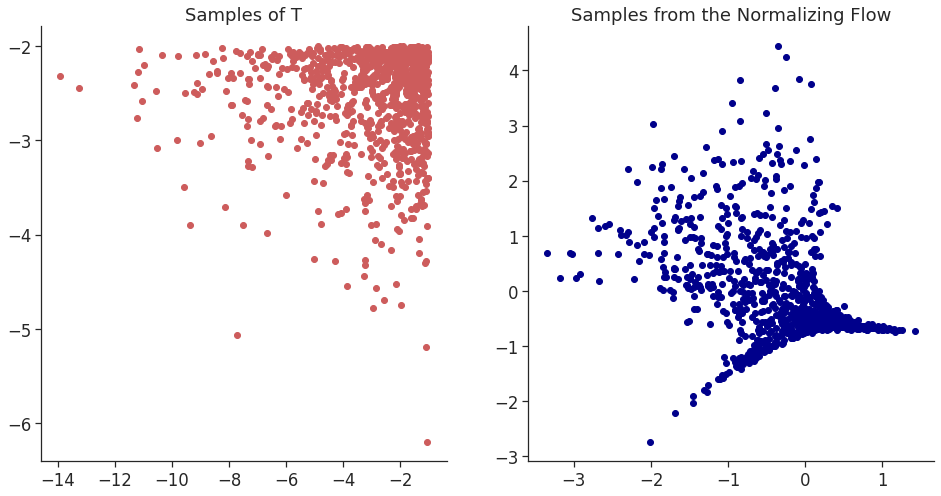

In [11]:
seed = 1234
n = 1000
random.seed(seed)
np.random.seed(seed)
torch.manual_seed(seed)
if torch.cuda.is_available():
    torch.cuda.manual_seed(seed)
    torch.cuda.manual_seed_all(seed)  # for multi-GPU setups

T_total = []
for j in range(d):
    U = np.random.uniform(0, 1, n)
    T = a[j]*np.log(U) - beta[j]
    T_total.append(T)
T_total = np.column_stack(T_total)

model = cf.GPDFlow(2)

sns.set(style="ticks",font_scale=1.5)
plt.figure(figsize=(16,8))
plt.subplot(1, 2, 1)
plt.scatter(T_total[:,0], T_total[:,1], alpha=1, color='indianred')
model.load_state_dict(torch.load(dir_out + f'model_{2}D_100_{0}.pt', weights_only=True))
model.eval()
samples_obs, samples_std, samples_T= model.sample(n)
plt.title('Samples of T')

plt.subplot(1, 2, 2)
plt.scatter(samples_T[:,0].cpu().data.numpy(), samples_T[:,1].cpu().data.numpy(), alpha=1, color='darkblue')
plt.title('Samples from the Normalizing Flow')


sns.despine()
plt.savefig(dir_out + 'Plots/'+'f_T_sample.pdf',bbox_inches='tight')
plt.show()

#### Calculate the theorical pairwise $\chi$ based on formula in Kirkiriliouk's paper

In [5]:
chi_values_theorical = cf.pairwise_chi_theorical(1/a)
chi_values_theorical

{'1-2': 0.5959389821791157,
 '1-3': 0.5645351568385462,
 '1-4': 0.3598892916940263,
 '1-5': 0.5318610619613964,
 '2-3': 0.71875,
 '2-4': 0.40792321620687566,
 '2-5': 0.6507777482864301,
 '3-4': 0.39186245321194657,
 '3-5': 0.612201755794261,
 '4-5': 0.3754625539543247}

#### Calculate the empirical $\chi$ from the GPDFlow by 10000 Monte Carlo samples

In [6]:
chi_values_empipical_2 = cf.pairwise_chi_empirical(dim=2,  n_monte_carlo=10000)
chi_values_empipical_3 = cf.pairwise_chi_empirical(dim=3,  n_monte_carlo=10000)
chi_values_empipical_5 = cf.pairwise_chi_empirical(dim=5,  n_monte_carlo=10000)

#### Compare the fitted $\chi$ with the true value

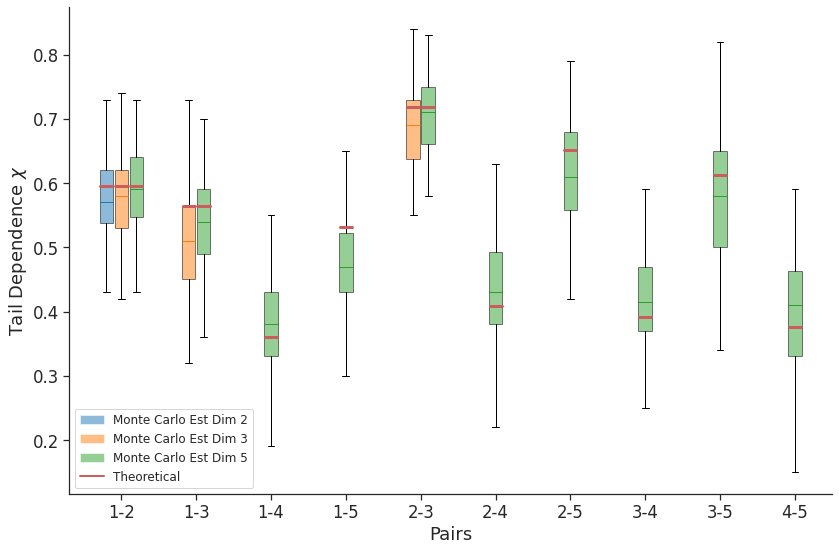

In [7]:
pairs = ['1-2', '1-3', '1-4', '1-5', '2-3', '2-4', '2-5', '3-4', '3-5', '4-5']

# Use the keys from the 5-dimensional dictionary as the full set of pairs.
all_keys = sorted(chi_values_empipical_5.keys())  # sorted in lexicographical order; adjust as needed
x_positions = np.arange(len(all_keys))

delta = 0.2  # spacing factor for box positions

sns.set(style="ticks", font_scale=1.5)
fig, ax = plt.subplots(figsize=(12, 8))

# Prepare a mapping from each key to a list of tuples (dimension, data)
# We use all_keys as the base so that the x-axis remains consistent.
data_by_key = {key: [] for key in all_keys}
for dim, chi_dict in [(2, chi_values_empipical_2),
                      (3, chi_values_empipical_3),
                      (5, chi_values_empipical_5)]:
    for key, data in chi_dict.items():
        if key in data_by_key:
            data_by_key[key].append((dim, data))

colors = {2: '#1f77b4', 3: '#ff7f0e', 5: '#2ca02c'}
alpha_value = 0.5

# Loop over each key and plot the boxplots for the dimensions available.
for i, key in enumerate(all_keys):
    # Sort by dimension to maintain a consistent order (2, then 3, then 5)
    items = sorted(data_by_key[key], key=lambda x: x[0])
    n = len(items)
    if n == 0:
        continue  
    # Compute offsets so that the available boxplots are centered.
    offsets = [ (j - (n-1)/2) * delta for j in range(n) ]
    # Plot each available boxplot at the computed offset
    for offset, (dim, data) in zip(offsets, items):
        pos = x_positions[i] + offset
        bp = ax.boxplot(data, positions=[pos], widths=0.18,
                        patch_artist=True, showfliers=False)
        for patch in bp['boxes']:
            patch.set_facecolor(colors[dim])
            patch.set_alpha(alpha_value)
        for median in bp['medians']:
            median.set_color(colors[dim])
        # Plot the theoretical line if available.
        if key in chi_values_theorical:
            theory_val = chi_values_theorical[key]
            ax.plot([pos - 0.08, pos + 0.08],
                    [theory_val, theory_val],
                    color='indianred', lw=3)

# Set x-axis labels.
ax.set_xticks(x_positions)
ax.set_xticklabels(all_keys)
ax.set_xlabel("Pairs")
ax.set_ylabel(r"Tail Dependence $\chi$")

# Add legend.
from matplotlib.patches import Patch
legend_elements = [Patch(facecolor=colors[dim], label=f'Monte Carlo Est Dim {dim}', alpha=alpha_value) for dim in [2, 3, 5]]
legend_elements.append(plt.Line2D([0], [0], color='indianred', lw=2, label='Theoretical'))
ax.legend(handles=legend_elements, loc='lower left',fontsize=12)
sns.despine()
plt.tight_layout()
plt.savefig(dir_out + 'Plots/'+f'Simulation_1_chi.pdf',bbox_inches='tight')
plt.show()

#### Get the estimated $\boldsymbol{\sigma}$ and $\boldsymbol{\gamma}$.

To get the estimated $\boldsymbol{\sigma}$ and $\boldsymbol{\gamma}$ from a single GPDFlow object called "model", one can use the following code:

model.data_transform.get_sigma()

model.data_transform.get_gamma()

In [9]:
sigma_dict_2, gamma_dict_2 = cf.marginal_parameter_monte_carlo(2)
sigma_dict_3, gamma_dict_3 = cf.marginal_parameter_monte_carlo(3)
sigma_dict_5, gamma_dict_5 = cf.marginal_parameter_monte_carlo(5)

In [10]:
sigma_true = dict(zip(['1', '2', '3', '4', '5'], sig))
gamma_true = dict(zip(['1', '2', '3', '4', '5'], gamma))

#### Compare the fitted $\boldsymbol{\sigma}$ with true values

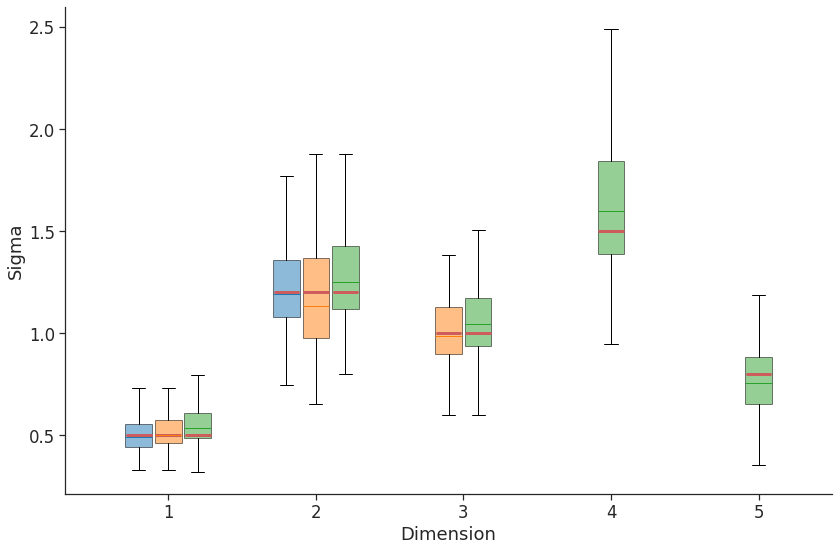

In [ ]:
pairs = ['1', '2', '3', '4', '5']

# Use the keys from the 5-dimensional dictionary as the full set of pairs.
all_keys = sorted(sigma_dict_5.keys())  
x_positions = np.arange(len(all_keys))

delta = 0.2  # spacing factor for box positions

sns.set(style="ticks", font_scale=1.5)
fig, ax = plt.subplots(figsize=(12, 8))

# Prepare a mapping from each key to a list of tuples (dimension, data)
# We use all_keys as the base so that the x-axis remains consistent.
data_by_key = {key: [] for key in all_keys}
for dim, chi_dict in [(2, sigma_dict_2),
                      (3, sigma_dict_3),
                      (5, sigma_dict_5)]:
    for key, data in chi_dict.items():
        if key in data_by_key:
            data_by_key[key].append((dim, data))

colors = {2: '#1f77b4', 3: '#ff7f0e', 5: '#2ca02c'}
alpha_value = 0.5

# Loop over each key and plot the boxplots for the dimensions available.
for i, key in enumerate(all_keys):
    # Sort by dimension to maintain a consistent order (2, then 3, then 5)
    items = sorted(data_by_key[key], key=lambda x: x[0])
    n = len(items)
    if n == 0:
        continue 
    # Compute offsets so that the available boxplots are centered.
    offsets = [ (j - (n-1)/2) * delta for j in range(n) ]
    # Plot each available boxplot at the computed offset
    for offset, (dim, data) in zip(offsets, items):
        pos = x_positions[i] + offset
        bp = ax.boxplot(data, positions=[pos], widths=0.18,
                        patch_artist=True, showfliers=False)
        for patch in bp['boxes']:
            patch.set_facecolor(colors[dim])
            patch.set_alpha(alpha_value)
        for median in bp['medians']:
            median.set_color(colors[dim])
        # Plot the theoretical line if available.
        if key in sigma_true:
            theory_val = sigma_true[key]
            ax.plot([pos - 0.08, pos + 0.08],
                    [theory_val, theory_val],
                    color='indianred', lw=3)

# Set x-axis labels.
ax.set_xticks(x_positions)
ax.set_xticklabels(all_keys)
ax.set_xlabel("Dimension")
ax.set_ylabel("Sigma")
# ax.set_title("Empirical Tail Dependence Boxplots with Theoretical Lines")

# Add legend.
# from matplotlib.patches import Patch
# legend_elements = [Patch(facecolor=colors[dim], label=f'Monte Calro Results in Dim {dim}', alpha=alpha_value) for dim in [2, 3, 5]]
# legend_elements.append(plt.Line2D([0], [0], color='darkorange', lw=2, label='Theoretical'))
# ax.legend(handles=legend_elements, loc='best',fontsize=15)
sns.despine()
plt.tight_layout()
plt.savefig(dir_out + 'Plots/'+f'Simulation_1_sigma.pdf',bbox_inches='tight')
plt.show()

#### Compare the fitted $\boldsymbol{\gamma}$ with true values

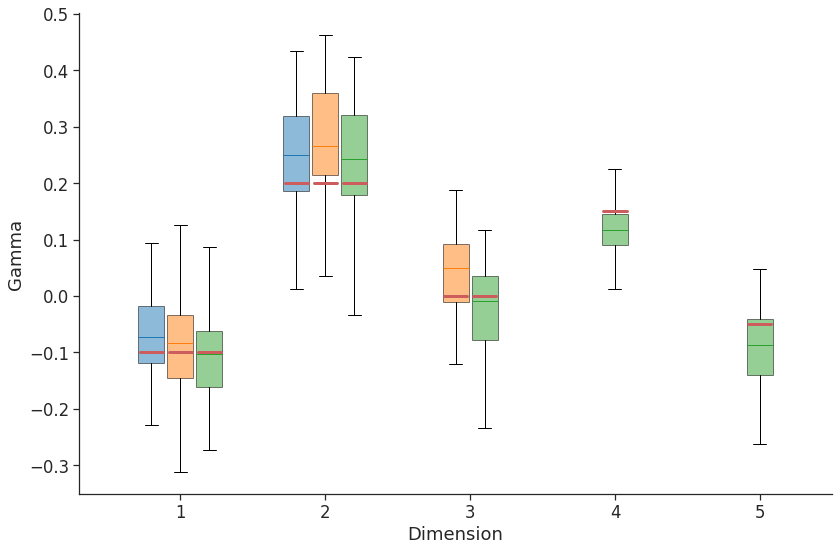

In [11]:
pairs = ['1', '2', '3', '4', '5']

# Use the keys from the 5-dimensional dictionary as the full set of pairs.
all_keys = sorted(gamma_dict_5.keys())  
x_positions = np.arange(len(all_keys))

delta = 0.2  # spacing factor for box positions

sns.set(style="ticks", font_scale=1.5)
fig, ax = plt.subplots(figsize=(12, 8))

# Prepare a mapping from each key to a list of tuples (dimension, data)
# We use all_keys as the base so that the x-axis remains consistent.
data_by_key = {key: [] for key in all_keys}
for dim, chi_dict in [(2, gamma_dict_2),
                      (3, gamma_dict_3),
                      (5, gamma_dict_5)]:
    for key, data in chi_dict.items():
        if key in data_by_key:
            data_by_key[key].append((dim, data))

colors = {2: '#1f77b4', 3: '#ff7f0e', 5: '#2ca02c'}
alpha_value = 0.5

# Loop over each key and plot the boxplots for the dimensions available.
for i, key in enumerate(all_keys):
    # Sort by dimension to maintain a consistent order (2, then 3, then 5)
    items = sorted(data_by_key[key], key=lambda x: x[0])
    n = len(items)
    if n == 0:
        continue 
    # Compute offsets so that the available boxplots are centered.
    offsets = [ (j - (n-1)/2) * delta for j in range(n) ]
    # Plot each available boxplot at the computed offset
    for offset, (dim, data) in zip(offsets, items):
        pos = x_positions[i] + offset
        bp = ax.boxplot(data, positions=[pos], widths=0.18,
                        patch_artist=True, showfliers=False)
        for patch in bp['boxes']:
            patch.set_facecolor(colors[dim])
            patch.set_alpha(alpha_value)
        for median in bp['medians']:
            median.set_color(colors[dim])
        # Plot the theoretical line if available.
        if key in gamma_true:
            theory_val = gamma_true[key]
            ax.plot([pos - 0.08, pos + 0.08],
                    [theory_val, theory_val],
                    color='indianred', lw=3)
                
# Set x-axis labels.
ax.set_xticks(x_positions)
ax.set_xticklabels(all_keys)
ax.set_xlabel("Dimension")
ax.set_ylabel("Gamma")
# ax.set_title("Empirical Tail Dependence Boxplots with Theoretical Lines")

# Add legend.
# from matplotlib.patches import Patch
# legend_elements = [Patch(facecolor=colors[dim], label=f'Monte Calro Results in Dim {dim}', alpha=alpha_value) for dim in [2, 3, 5]]
# legend_elements.append(plt.Line2D([0], [0], color='darkorange', lw=2, label='Theoretical'))
# ax.legend(handles=legend_elements, loc='best',fontsize=15)
sns.despine()
plt.tight_layout()
plt.savefig(dir_out + 'Plots/'+f'Simulation_1_gamma.pdf',bbox_inches='tight')
plt.show()